# Regularization example

Here' the plan:

* generate some fake data in 2D so we can plot it
* build a neural network classifier with a single hidden layer
* train the network with different $L_{2}$-norm regularization strengths, and look at:
    * train and test loss
    * overall accuracy
    * RMS values of the weight matrices
    * the decision boundary

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib
from tqdm import tqdm

import sklearn.decomposition, sklearn.datasets
from tensorflow.contrib import slim

%matplotlib inline
from IPython.core.pylabtools import figsize

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.5.0'

## Generate some data

2 classes, in two dimensions

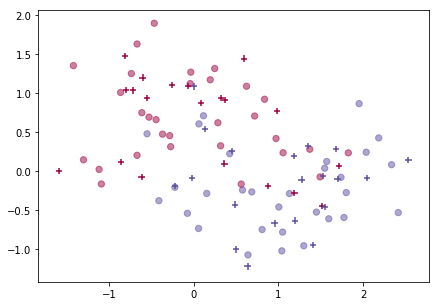

In [3]:
figsize(7,5)
np.random.seed(0)
X_train, y_train = sklearn.datasets.make_moons(60, noise=0.4)
X_test, y_test = sklearn.datasets.make_moons(40, noise=0.4)

plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, marker="o", cmap=plt.cm.Spectral, alpha=0.5)
plt.scatter(X_test[:,0], X_test[:,1], s=40, c=y_test, marker="+", cmap=plt.cm.Spectral);

## Build the network

In [4]:
tf.reset_default_graph()

In [5]:
num_hidden = 100
learnrate = 0.1


# Inputs
x = tf.placeholder(tf.float32, [None, 2], name="data_placeholder")
y_ = tf.placeholder(tf.int32, [None,], name="label_placeholder")
y_oh = tf.one_hot(y_, 2, name="labels_one_hot")

# Placeholder for the regularization strength
reg_ph = tf.placeholder(tf.float32, [], name="reg_placeholder")

# The neural network goes here- just two layers
hidden = tf.layers.dense(x, num_hidden, activation=tf.nn.sigmoid, name="hidden",
                        kernel_initializer=tf.random_normal_initializer(0, 0.01))
logits = tf.layers.dense(hidden, 2,  name="output",
                        kernel_initializer=tf.random_normal_initializer(0, 0.01))
y = tf.nn.softmax(logits)

# pull out the weight for each layer and compute the RMS
weights = [w for w in tf.global_variables() if "kernel" in w.name]
squared_weights = tf.reduce_sum(tf.pow(weights[0],2)) + tf.reduce_sum(tf.pow(weights[1],2))
rms_weights = tf.sqrt(squared_weights)

# the loss function is cross entropy + the squared L2 norm of the weights
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=logits))
loss = cross_entropy + reg_ph*squared_weights

# optimize with gradient descent
optimizer = tf.train.GradientDescentOptimizer(learnrate)
train_step = optimizer.minimize(loss)

# compute predictions and accuracy
prediction = tf.argmax(y,1)
correct_prediction = tf.equal(prediction, tf.argmax(y_oh,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



## Regularization experiment

In [6]:
def regularization_experiment(r=1e-8, train_steps=150000):
    """
    Input a regularization strength, initialize the network, 
    train it, and plot a bunch of crap
    """
    train_loss = []
    test_loss = []
    rms_vals = []
    xx, yy = np.meshgrid(np.linspace(-3,3,250), np.linspace(-3,3,250))
    grid_inputs = np.hstack([xx.reshape(-1,1), yy.reshape(-1,1)])
    
    train_fd = {x:X_train, y_:y_train, reg_ph:r}
    test_fd = {x:X_test, y_:y_test, reg_ph:r}
    grid_fd = {x:grid_inputs, reg_ph:r}
    
    with tf.Session() as sess:
        # initialize the variables
        sess.run(tf.global_variables_initializer())
        for t in tqdm(range(train_steps)):
            _, tl = sess.run([train_step, cross_entropy], feed_dict=train_fd)
            train_loss.append(tl)
            tl, rv = sess.run([cross_entropy, rms_weights], feed_dict=test_fd)
            test_loss.append(tl)
            rms_vals.append(rv)
            
        grid_outputs = sess.run(y, feed_dict=grid_fd)[:,1].reshape(xx.shape)
        test_acc = sess.run(accuracy, feed_dict=test_fd)
        
    plt.subplot(2,2,1)
    plt.plot(train_loss, lw=2, label="train")
    plt.plot(test_loss, lw=2, label="test")
    plt.legend(loc="upper right")
    plt.ylabel("cross entropy", fontsize=14)

    plt.subplot(2,2,3)
    plt.plot(rms_vals)
    plt.xlabel("training step", fontsize=14)
    plt.ylabel("size of weights", fontsize=14)
    
    plt.subplot(1,2,2)
    plt.contourf(xx, yy, grid_outputs)
    plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, marker="o", cmap=plt.cm.Spectral, alpha=0.5)
    plt.scatter(X_test[:,0], X_test[:,1], s=40, c=y_test, marker="+", cmap=plt.cm.Spectral)
    plt.title("Final test accuracy: %s"%round(test_acc,4))

## TOO SMALL

100%|██████████| 150000/150000 [02:54<00:00, 858.63it/s]


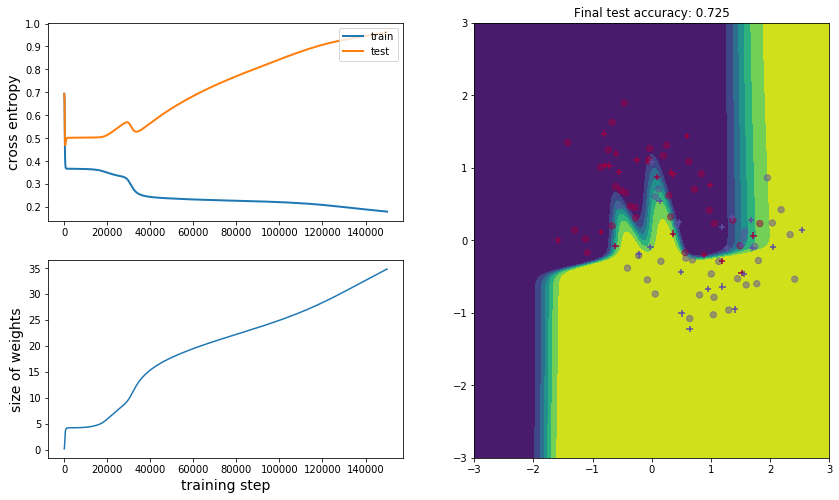

In [7]:
figsize(14,8)
regularization_experiment(1e-10)

## TOO BIG

100%|██████████| 150000/150000 [02:57<00:00, 846.38it/s]


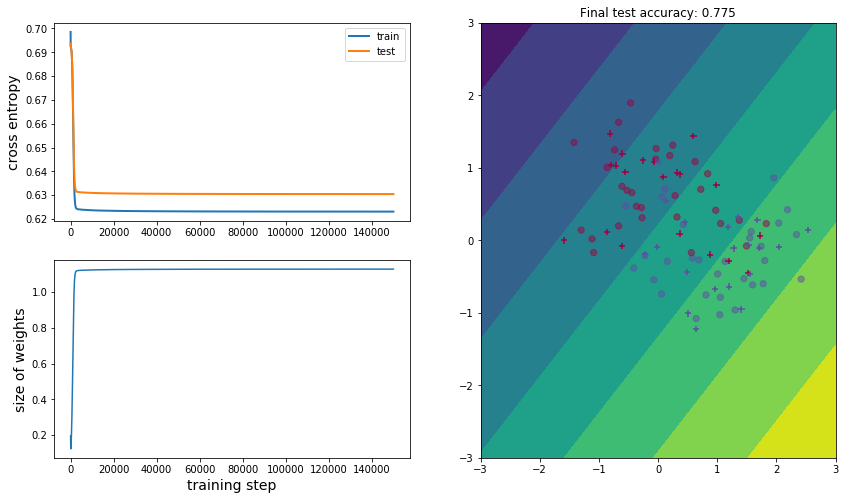

In [8]:
figsize(14,8)
regularization_experiment(0.05)

## JUST RIGHT

100%|██████████| 150000/150000 [02:58<00:00, 840.86it/s]


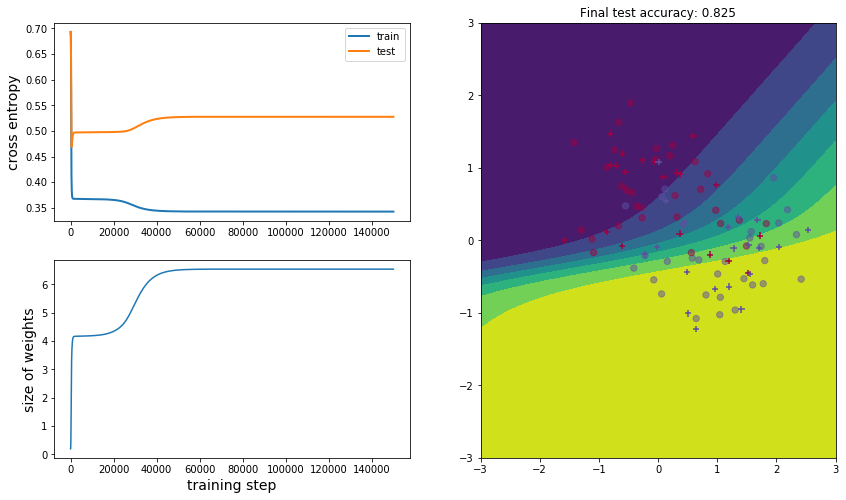

In [9]:
figsize(14,8)
regularization_experiment(5e-4)